In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [4]:
df = pd.read_csv('ca_wildfire_weather.csv')

### Data Prep

In [5]:
df.head()

,Unnamed: 0,Object_ID,Fire_Occurrence_Database_ID,Fire_Program_Analysis_ID,Reporting_Agency,Reporting_Unit_Name,Fire_Year,Discovery_Date,Discovery_Day_of_Year,Discovery_Time,...,State,FIPS_Name,Week_Before_Discovery_Date,Avg_Max_Temp,Avg_Min_Temp,Avg_Precipitation,Avg_Sunshine,Avg_Wind_Speed,Avg_Wind_Gusts,Primary_Wind_Direction
0,0,17,17,FS-1418878,FS,Eldorado National Forest,2004,2004-10-06,280,1415.0,...,CA,Amador County,2004-09-29,68.0750,41.7000,0.026125,37818.11125,6.6875,22.1375,139.875
1,1,18,18,FS-1418881,FS,Eldorado National Forest,2004,2004-10-13,287,1618.0,...,CA,El Dorado County,2004-10-06,70.5375,48.9000,0.001000,37670.53375,10.9750,33.3750,151.000
2,2,549,556,FS-1420078,FS,Sequoia National Forest,2005,2005-07-09,190,1313.0,...,CA,NaN,2005-07-02,93.3875,68.7500,0.000000,48823.62625,6.7500,24.2500,304.500
3,3,1500,1514,FS-1422180,FS,Cleveland National Forest,2005,2005-08-24,236,1110.0,...,CA,NaN,2005-08-17,85.4250,64.9000,0.000000,43949.38375,7.7750,20.0125,284.875
4,4,2723,2740,FS-1424833,FS,Mendocino National Forest,2005,2005-09-16,259,1435.0,...,CA,NaN,2005-09-09,76.4500,52.9875,0.000000,41695.45250,8.6250,27.2125,295.375


In [6]:
df.columns

Index(['Unnamed: 0', 'Object_ID', 'Fire_Occurrence_Database_ID',
       'Fire_Program_Analysis_ID', 'Reporting_Agency', 'Reporting_Unit_Name',
       'Fire_Year', 'Discovery_Date', 'Discovery_Day_of_Year',
       'Discovery_Time', 'Cause_Classification', 'General_Cause',
       'Fire_Size_Acres', 'Fire_Size_Class', 'Latitude', 'Longitude', 'State',
       'FIPS_Name', 'Week_Before_Discovery_Date', 'Avg_Max_Temp',
       'Avg_Min_Temp', 'Avg_Precipitation', 'Avg_Sunshine', 'Avg_Wind_Speed',
       'Avg_Wind_Gusts', 'Primary_Wind_Direction'],
      dtype='object')

In [7]:
# Drop unnecessary columns that we dont need for prediction model
drop_columns = ['Unnamed: 0', 'Object_ID', 'Fire_Occurrence_Database_ID',
                'Fire_Program_Analysis_ID', 'Reporting_Agency', 'Reporting_Unit_Name', 'Discovery_Day_of_Year',
                'State', 'FIPS_Name', 'General_Cause', 'Week_Before_Discovery_Date']
df = df.drop(columns=drop_columns)

In [8]:
df.columns

Index(['Fire_Year', 'Discovery_Date', 'Discovery_Time', 'Cause_Classification',
       'Fire_Size_Acres', 'Fire_Size_Class', 'Latitude', 'Longitude',
       'Avg_Max_Temp', 'Avg_Min_Temp', 'Avg_Precipitation', 'Avg_Sunshine',
       'Avg_Wind_Speed', 'Avg_Wind_Gusts', 'Primary_Wind_Direction'],
      dtype='object')

In [9]:
df.dtypes

Fire_Year                   int64
Discovery_Date             object
Discovery_Time            float64
Cause_Classification       object
Fire_Size_Acres           float64
Fire_Size_Class            object
Latitude                  float64
Longitude                 float64
Avg_Max_Temp              float64
Avg_Min_Temp              float64
Avg_Precipitation         float64
Avg_Sunshine              float64
Avg_Wind_Speed            float64
Avg_Wind_Gusts            float64
Primary_Wind_Direction    float64
dtype: object

In [10]:
# Filter to keep only the desired classes (drop undetermined)
df = df[df['Cause_Classification'].isin(['Human', 'Natural'])]

In [11]:
# Encode the target variable (Human = 1, Natural = 0)
label_encoder = LabelEncoder()
df['Cause_Classification'] = label_encoder.fit_transform(df['Cause_Classification'])

In [12]:
# Convert 'Discovery_Date' to datetime 
df['Discovery_Date'] = pd.to_datetime(df['Discovery_Date'], errors='coerce')

In [13]:
# Creating a season column to use as feature to better capture variability in fire occurences throughout year, allowing model to learn patterns related to each season.

# Extract month from Discovery_Date
df['Month'] = df['Discovery_Date'].dt.month

# map month to season
def get_season(month):
    if month in [12, 1, 2]:  # dec, jan, feb
        return 'Winter'
    elif month in [3, 4, 5]:  # mar, apr, may
        return 'Spring'
    elif month in [6, 7, 8]:  # jun, jul, aug
        return 'Summer'
    else:
        return 'Fall'  # sep, oct, nov

# Apply function to create 'Season' col
df['Season'] = df['Month'].apply(get_season)

# Drop month col as no longer needed
df.drop('Month', axis=1, inplace=True)

df[['Discovery_Date', 'Season']].head()

,Discovery_Date,Season
0,2004-10-06,Fall
1,2004-10-13,Fall
2,2005-07-09,Summer
3,2005-08-24,Summer
4,2005-09-16,Fall


In [14]:
# One-hot encoding for season
df = pd.get_dummies(df, columns=['Season'], drop_first=True)

In [15]:
df.dtypes

Fire_Year                          int64
Discovery_Date            datetime64[ns]
Discovery_Time                   float64
Cause_Classification               int64
Fire_Size_Acres                  float64
Fire_Size_Class                   object
Latitude                         float64
Longitude                        float64
Avg_Max_Temp                     float64
Avg_Min_Temp                     float64
Avg_Precipitation                float64
Avg_Sunshine                     float64
Avg_Wind_Speed                   float64
Avg_Wind_Gusts                   float64
Primary_Wind_Direction           float64
Season_Spring                       bool
Season_Summer                       bool
Season_Winter                       bool
dtype: object

In [16]:
df = pd.get_dummies(df, columns=['Fire_Size_Class'], drop_first=True)

In [17]:
df.columns

Index(['Fire_Year', 'Discovery_Date', 'Discovery_Time', 'Cause_Classification',
       'Fire_Size_Acres', 'Latitude', 'Longitude', 'Avg_Max_Temp',
       'Avg_Min_Temp', 'Avg_Precipitation', 'Avg_Sunshine', 'Avg_Wind_Speed',
       'Avg_Wind_Gusts', 'Primary_Wind_Direction', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'Fire_Size_Class_E',
       'Fire_Size_Class_F', 'Fire_Size_Class_G'],
      dtype='object')

In [18]:
# Check for missing values in the dataset
df.isnull().sum()

Fire_Year                   0
Discovery_Date              0
Discovery_Time            984
Cause_Classification        0
Fire_Size_Acres             0
Latitude                    0
Longitude                   0
Avg_Max_Temp                0
Avg_Min_Temp                0
Avg_Precipitation           0
Avg_Sunshine                0
Avg_Wind_Speed              0
Avg_Wind_Gusts              0
Primary_Wind_Direction      0
Season_Spring               0
Season_Summer               0
Season_Winter               0
Fire_Size_Class_E           0
Fire_Size_Class_F           0
Fire_Size_Class_G           0
dtype: int64

In [19]:
total_count = df.shape[0]  
print(f"Total records in the dataset: {total_count}")

missing_times_count = df['Discovery_Time'].isna().sum()  
print(f"Missing Discovery_Time values: {missing_times_count}")

missing_percentage = (missing_times_count / total_count) * 100
print(f"Percentage of missing Discovery_Time values: {missing_percentage:.2f}%")

Total records in the dataset: 4899
Missing Discovery_Time values: 984
Percentage of missing Discovery_Time values: 20.09%


Dropping the rows is not a good aproach--could disclude discovery time as a feature or categorize it and fill in nan with unknown, then one-hot encode.
Going to proceed with categories and one hot encoding first

Categorizing by:
- Morning: 5:00 AM to 11:59 AM (5-11)
- Afternoon: 12:00 PM to 5:59 PM (12-17)
- Evening: 6:00 PM to 8:59 PM (18-20)
- Night: 9:00 PM to 4:59 AM (21-4)
- Unknown: NaN values

In [20]:
# categorizing discovery time into morning, afternoon, evening, night, unknown to deal with missing floats

# function to categorize Discovery_Time
def categorize_time(row):
    if np.isnan(row):
        return 'Unknown'
    hour = int(row // 100)  # Get the hour part (e.g., 1415 becomes 14)
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Apply the categorization
df['Time_Category'] = df['Discovery_Time'].apply(categorize_time)

# One-Hot Encode the new categorical column
df = pd.get_dummies(df, columns=['Time_Category'], drop_first=True)

# Check the result
df.head()

,Fire_Year,Discovery_Date,Discovery_Time,Cause_Classification,Fire_Size_Acres,Latitude,Longitude,Avg_Max_Temp,Avg_Min_Temp,Avg_Precipitation,...,Season_Spring,Season_Summer,Season_Winter,Fire_Size_Class_E,Fire_Size_Class_F,Fire_Size_Class_G,Time_Category_Evening,Time_Category_Morning,Time_Category_Night,Time_Category_Unknown
0,2004,2004-10-06,1415.0,0,16823.0,38.523333,-120.211667,68.0750,41.7000,0.026125,...,False,False,False,False,False,True,False,False,False,False
1,2004,2004-10-13,1618.0,0,7700.0,38.780000,-120.260000,70.5375,48.9000,0.001000,...,False,False,False,False,False,True,False,False,False,False
2,2005,2005-07-09,1313.0,0,1149.0,35.688056,-118.438333,93.3875,68.7500,0.000000,...,False,True,False,False,True,False,False,False,False,False
3,2005,2005-08-24,1110.0,0,124.0,32.681944,-116.640000,85.4250,64.9000,0.000000,...,False,True,False,False,False,False,False,True,False,False
4,2005,2005-09-16,1435.0,0,775.0,39.169722,-122.887222,76.4500,52.9875,0.000000,...,False,False,False,True,False,False,False,False,False,False


In [21]:
df.dtypes

Fire_Year                          int64
Discovery_Date            datetime64[ns]
Discovery_Time                   float64
Cause_Classification               int64
Fire_Size_Acres                  float64
Latitude                         float64
Longitude                        float64
Avg_Max_Temp                     float64
Avg_Min_Temp                     float64
Avg_Precipitation                float64
Avg_Sunshine                     float64
Avg_Wind_Speed                   float64
Avg_Wind_Gusts                   float64
Primary_Wind_Direction           float64
Season_Spring                       bool
Season_Summer                       bool
Season_Winter                       bool
Fire_Size_Class_E                   bool
Fire_Size_Class_F                   bool
Fire_Size_Class_G                   bool
Time_Category_Evening               bool
Time_Category_Morning               bool
Time_Category_Night                 bool
Time_Category_Unknown               bool
dtype: object

In [22]:
df.drop(['Discovery_Time', 'Discovery_Date'], axis=1, inplace=True)

In [23]:
df.columns

Index(['Fire_Year', 'Cause_Classification', 'Fire_Size_Acres', 'Latitude',
       'Longitude', 'Avg_Max_Temp', 'Avg_Min_Temp', 'Avg_Precipitation',
       'Avg_Sunshine', 'Avg_Wind_Speed', 'Avg_Wind_Gusts',
       'Primary_Wind_Direction', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'Fire_Size_Class_E', 'Fire_Size_Class_F',
       'Fire_Size_Class_G', 'Time_Category_Evening', 'Time_Category_Morning',
       'Time_Category_Night', 'Time_Category_Unknown'],
      dtype='object')

### Define feature and target variables

In [24]:
# define features and target variable
X = df.drop(columns=['Cause_Classification'])  # features
y = df['Cause_Classification']  # target

### Initial Model Performance

In [37]:
# Initialize lists to store F1 scores
f1_scores_human = []
f1_scores_natural = []

# Loop for 50 iterations
for i in range(50):
    # Change train-test split for each iteration
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Create and train SVM model
    model = SVC(kernel='rbf', C=1, gamma='scale')  
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate F1 scores for each class
    f1_scores = f1_score(y_test, y_pred, average=None)  

    # Append F1 scores to lists
    f1_scores_human.append(f1_scores[0])   # class 0 = Human Caused
    f1_scores_natural.append(f1_scores[1])  # class 1 = Natural Caused

# Calculate avg and std dev of F1 scores for each class
average_f1_human = np.mean(f1_scores_human)
std_f1_human = np.std(f1_scores_human)

average_f1_natural = np.mean(f1_scores_natural)
std_f1_natural = np.std(f1_scores_natural)

# results
print(f'Average F1 Score (Human Caused): {average_f1_human:.4f}')
print(f'Standard Deviation (Human Caused): {std_f1_human:.4f}')

print(f'Average F1 Score (Natural Caused): {average_f1_natural:.4f}')
print(f'Standard Deviation (Natural Caused): {std_f1_natural:.4f}')

Average F1 Score (Human Caused): 0.8714
Standard Deviation (Human Caused): 0.0077
Average F1 Score (Natural Caused): 0.0057
Standard Deviation (Natural Caused): 0.0061


- Human caused fires are predicted well, while naturally occuring fires are predicted very poorly
- This is likely due to imbalanced classes (natural being the minority)

#### Adding SMOTE for Class Imbalance

In [38]:
# Initialize lists to store F1 scores
f1_scores_human = []
f1_scores_natural = []

for i in range(50):
    # Change train-test split for each iteration
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Apply SMOTE to balance the classes in the training data
    smote = SMOTE(random_state=i)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Create and train the SVM model
    model = SVC(kernel='rbf', C=1, gamma='scale')  # same params as before
    model.fit(X_resampled, y_resampled)

    # Make predictions on test set
    y_pred = model.predict(X_test)

    # Calculate F1 scores for each class
    f1_scores = f1_score(y_test, y_pred, average=None)

    # Append F1 scores to lists
    f1_scores_human.append(f1_scores[0])
    f1_scores_natural.append(f1_scores[1])

# Calculate avg and std dev of F1 scores for each class
average_f1_human = np.mean(f1_scores_human)
std_f1_human = np.std(f1_scores_human)

average_f1_natural = np.mean(f1_scores_natural)
std_f1_natural = np.std(f1_scores_natural)

print(f'Average F1 Score (Human Caused): {average_f1_human:.4f}')
print(f'Standard Deviation (Human Caused): {std_f1_human:.4f}')

print(f'Average F1 Score (Natural Caused): {average_f1_natural:.4f}')
print(f'Standard Deviation (Natural Caused): {std_f1_natural:.4f}')

Average F1 Score (Human Caused): 0.6960
Standard Deviation (Human Caused): 0.0894
Average F1 Score (Natural Caused): 0.3785
Standard Deviation (Natural Caused): 0.0211


#### Hyperparameter Tuning with Randomized Search CV to Enhance Performance

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

param_distributions = {
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__kernel': ['rbf', 'linear', 'sigmoid'],
    'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'svc__class_weight': ['balanced']
}

randomized_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,  
    verbose=2,
    random_state=i,
    n_jobs=-1  
)

smote = SMOTE(random_state=i)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

randomized_search.fit(X_resampled, y_resampled)

print("Best Parameters:", randomized_search.best_params_)
print("Best Cross-validation Score:", randomized_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'svc__kernel': 'rbf', 'svc__gamma': 'auto', 'svc__class_weight': 'balanced', 'svc__C': 10}
Best Cross-validation Score: 0.8925864909390444


#### Final Model Evaluation Using Best Params, Applying SMOTE, and Scaling 

In [40]:
# Best parameters obtained from RandomizedSearchCV
best_params = {
    'kernel': 'rbf',
    'gamma': 'auto',
    'class_weight': 'balanced',
    'C': 10
}

# Train and evaluate the model 50 times with different splits
f1_scores_natural = []
f1_scores_human = []

for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    smote = SMOTE(random_state=i)
    X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

    best_model = SVC(**best_params)
    best_model.fit(X_resampled, y_resampled)  

    y_pred = best_model.predict(X_test_scaled)

    f1_scores = f1_score(y_test, y_pred, average=None)  

    f1_scores_human.append(f1_scores[0])  # human caused
    f1_scores_natural.append(f1_scores[1])  # naturally caused

average_f1_human = np.mean(f1_scores_human)
std_f1_human = np.std(f1_scores_human)

average_f1_natural = np.mean(f1_scores_natural)
std_f1_natural = np.std(f1_scores_natural)

print(f'Average F1 Score (Human Caused): {average_f1_human:.4f}')
print(f'Standard Deviation (Human Caused): {std_f1_human:.4f}')

print(f'Average F1 Score (Natural Caused): {average_f1_natural:.4f}')
print(f'Standard Deviation (Natural Caused): {std_f1_natural:.4f}')

Average F1 Score (Human Caused): 0.9012
Standard Deviation (Human Caused): 0.0074
Average F1 Score (Natural Caused): 0.6859
Standard Deviation (Natural Caused): 0.0194
[CV] END svc__C=100, svc__class_weight=balanced, svc__gamma=0.01, svc__kernel=rbf; total time=   4.0s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf; total time=   3.8s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf; total time=   4.9s
[CV] END svc__C=1, svc__class_weight=balanced, svc__gamma=0.01, svc__kernel=linear; total time=   3.6s
[CV] END svc__C=0.01, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear; total time=   2.5s
[CV] END svc__C=0.01, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf; total time=   6.4s
[CV] END svc__C=1, svc__class_weight=balanced, svc__gamma=0.001, svc__kernel=sigmoid; total time=   3.1s
[CV] END svc__C=100, svc__class_weight=balanced, svc__gamma=1, svc__kernel=sigmoid; total time=   3.6s
[CV]

### Visual of Model Improvements

In [46]:
# F1 scores for human caused and natural caused for each model stage
steps = ['Initial Model', 'After SMOTE', 'After Hyperparameter Tuning']
human_caused_scores = [0.8714, 0.6960, 0.9012]  
natural_caused_scores = [0.0057, 0.3785, 0.6859]  

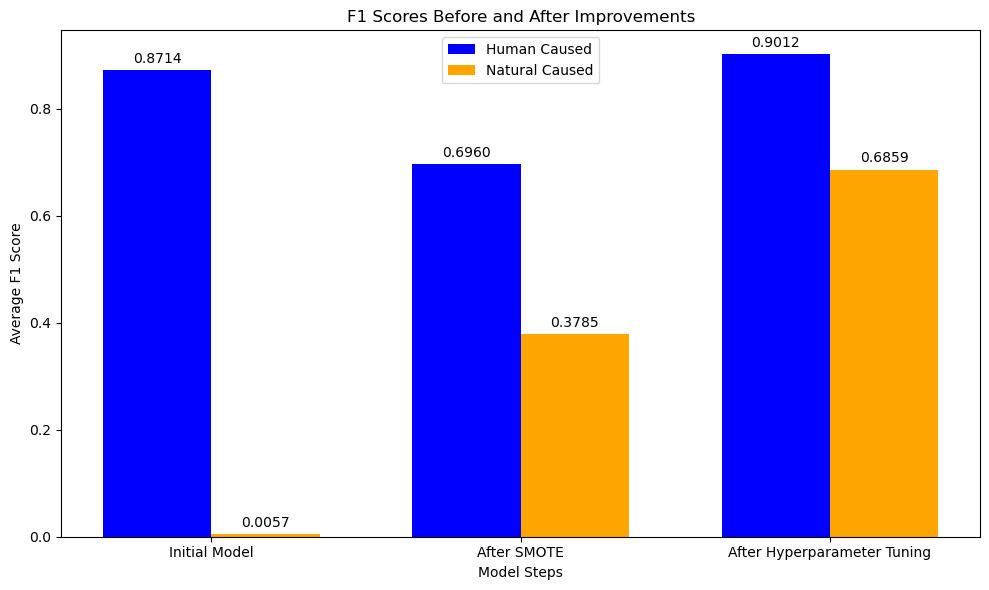

In [47]:
x = np.arange(len(steps))  
width = 0.35  

# Create charts
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, human_caused_scores, width, label='Human Caused', color='blue')
bars2 = ax.bar(x + width/2, natural_caused_scores, width, label='Natural Caused', color='orange')

ax.set_xlabel('Model Steps')
ax.set_ylabel('Average F1 Score')
ax.set_title('F1 Scores Before and After Improvements')
ax.set_xticks(x)
ax.set_xticklabels(steps)
ax.legend()

def add_data_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.annotate(f'{yval:.4f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, yval), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom')

add_data_labels(bars1)
add_data_labels(bars2)

plt.tight_layout()
plt.show()